In [53]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from mydatools.plot import plot_grid_search_result
from mydatools.features_analyze import get_top_k_corr

% matplotlib inline

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

dropoff_datetime  dropoff_latitude  dropoff_longitude         id  \
train 0  2016-03-14 17:32:30         40.765602         -73.964630  id2875421   
      1  2016-06-12 00:54:38         40.731152         -73.999481  id2377394   
      2  2016-01-19 12:10:48         40.710087         -74.005333  id3858529   
      3  2016-04-06 19:39:40         40.706718         -74.012268  id3504673   
      4  2016-03-26 13:38:10         40.782520         -73.972923  id2181028   

         passenger_count      pickup_datetime  pickup_latitude  \
train 0                1  2016-03-14 17:24:55        40.767937   
      1                1  2016-06-12 00:43:35        40.738564   
      2                1  2016-01-19 11:35:24        40.763939   
      3                1  2016-04-06 19:32:31        40.719971   
      4                1  2016-03-26 13:30:55        40.793209   

         pickup_longitude store_and_fwd_flag  trip_duration  vendor_id  
train 0        -73.982155                  N          455.0          2  
      1        -73.980415                  N          663.0          1  
      2        -73.979027                  N         2124.0          2  
      3        -74.010040                  N          429.0          2  
      4        -73.973053                  N          435.0          2

In [3]:
full_df['log1p_trip_duration'] = np.log1p(full_df['trip_duration'])

## feature

In [4]:
feature_columns = [
    'passenger_count', 'vendor_id',
    'store_and_fwd_flag',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude', 
]

In [5]:
def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

In [6]:
full_df['store_and_fwd_flag'] = full_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

* Addition Data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm

In [7]:
usecols = ['id', 'total_distance', 'total_travel_time', 'number_of_steps']
fr_df = pd.concat([    
    pd.read_csv('./data/input/fastest_routes_train_part_1.csv', usecols=usecols),
    pd.read_csv('./data/input/fastest_routes_train_part_2.csv', usecols=usecols),
    pd.read_csv('./data/input/fastest_routes_test.csv', usecols=usecols),
])

In [8]:
full_df_index = full_df.index
full_df = full_df.merge(fr_df, how='left', on='id')
full_df.index = full_df_index

In [9]:
add_features(['total_distance', 'total_travel_time', 'number_of_steps'])

* generate datetime features

In [10]:
def gen_datetime_feature(prefix):
    # datetime features
    f_datetime = prefix + '_datetime'
    attr_list = [
#         'year', 
        'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear',
        'hour', 'minute',
    ]

    full_df[f_datetime] = pd.to_datetime(full_df[f_datetime])
    for attr in attr_list:
        full_df[prefix+'_'+attr] = eval("full_df[f_datetime].dt."+attr)
        add_features(prefix+'_'+attr)
    
    full_df[prefix+'_hour_minute'] = full_df[prefix+'_hour'] * 60 + full_df[prefix+'_minute']
    full_df[prefix+'_week_hour'] = full_df[prefix+'_dayofweek'] * 24 + full_df[prefix+'_hour']
    full_df[prefix+'_week_hour_minute'] = full_df[prefix+'_week_hour'] * 60 + full_df[prefix+'_minute']
    full_df[prefix+'_total_seconds'] = (full_df[f_datetime] - full_df[f_datetime].min()).dt.total_seconds()
    add_features([
        prefix+'_hour_minute', prefix+'_week_hour',
        prefix+'_week_hour_minute', prefix+'_total_seconds',
    ])
    
    full_df[prefix+'_date'] = full_df[f_datetime].dt.date

gen_datetime_feature('pickup')
# gen_datetime_feature('dropoff') # 注意 这个不能用 下车时间是结果的一个信息

* riding distance

In [11]:
xy_distance = np.c_[
    (full_df['dropoff_latitude'] - full_df['pickup_latitude']).values,
    (full_df['dropoff_longitude'] - full_df['pickup_longitude']).values,
]
full_df['distance_p2'] = np.linalg.norm(xy_distance, 2, axis=1)
full_df['distance_p1'] = np.linalg.norm(xy_distance, 1, axis=1)
add_features(['distance_p2', 'distance_p1'])

* cluster

In [12]:
all_coords = np.vstack((
    full_df[['pickup_longitude', 'pickup_latitude']].values,
    full_df[['dropoff_longitude', 'dropoff_latitude']].values,
))

In [13]:
kmeans = KMeans(20).fit(all_coords)

In [14]:
full_df['pickup_cluster_label'] = kmeans.predict(full_df[['pickup_longitude', 'pickup_latitude']])
full_df['dropoff_cluster_label'] = kmeans.predict(full_df[['dropoff_longitude', 'dropoff_latitude']])

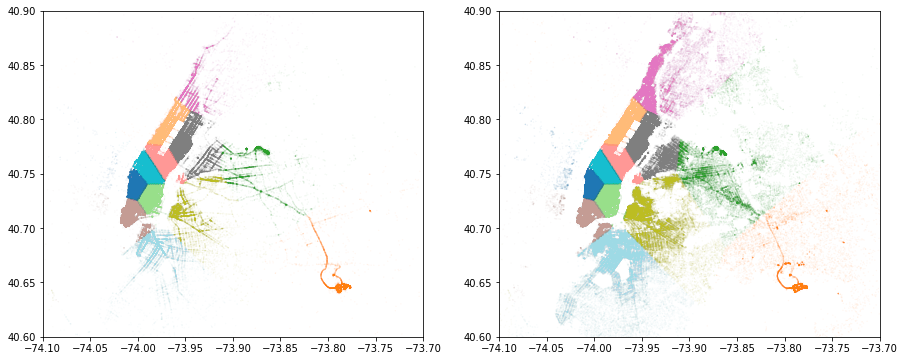

In [15]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.xlim(-74.1, -73.7)
plt.ylim(40.6, 40.9)
plt.scatter(full_df['pickup_longitude'], full_df['pickup_latitude'], c=full_df['pickup_cluster_label'], s=0.05, alpha=0.1, cmap=plt.cm.tab20)

plt.subplot(122)
plt.xlim(-74.1, -73.7)
plt.ylim(40.6, 40.9)
plt.scatter(full_df['dropoff_longitude'], full_df['dropoff_latitude'], c=full_df['dropoff_cluster_label'], s=0.05, alpha=0.1, cmap=plt.cm.tab20)

* speed

In [16]:
# 速度
full_df['speed'] = (full_df['distance_p2'] / full_df['trip_duration'] * 3600).clip(0, 1)
full_df['speed_p1'] = (full_df['distance_p1'] / full_df['trip_duration'] * 3600).clip(0, 1)
full_df['fr_speed'] = (full_df['total_distance'] / full_df['total_travel_time']).fillna(0).replace(np.inf, 0)

In [17]:
pos_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

In [18]:
# longitude/latitude bin
for pos_f in pos_feats:
    full_df[pos_f+'_bin'] = full_df[pos_f].round(2)
    add_features(pos_f+'_bin')

In [66]:
# 某些组合后所对应的平均速度
gp_cols_list = [
    ['pickup_longitude_bin', 'pickup_latitude_bin'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin'],
    ['pickup_dayofweek'],
    ['pickup_hour'],
    ['pickup_minute'],
    ['pickup_hour_minute'],
    ['pickup_week_hour'],
    ['pickup_week_hour_minute'],
    ['pickup_dayofyear'],
    ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_dayofweek'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_dayofweek'],
    ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_hour'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_hour'],
    ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_minute'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_minute'],
    ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_hour_minute'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_hour_minute'],
    ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_week_hour'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_week_hour'],
#     ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_week_hour_minute'],
#     ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_week_hour_minute'],
    ['pickup_longitude_bin', 'pickup_latitude_bin', 'pickup_dayofyear'],
    ['dropoff_longitude_bin', 'dropoff_latitude_bin', 'pickup_dayofyear'],
    
    ['pickup_cluster_label'], 
    ['dropoff_cluster_label'],
    ['pickup_cluster_label', 'pickup_dayofweek'],
    ['dropoff_cluster_label', 'pickup_dayofweek'],
    ['pickup_cluster_label', 'pickup_hour'],
    ['dropoff_cluster_label', 'pickup_hour'],
    ['pickup_cluster_label', 'pickup_minute'],
    ['dropoff_cluster_label', 'pickup_minute'],
    ['pickup_cluster_label', 'pickup_hour_minute'],
    ['dropoff_cluster_label', 'pickup_hour_minute'],
    ['pickup_cluster_label', 'pickup_week_hour'],
    ['dropoff_cluster_label', 'pickup_week_hour'],
#     ['pickup_cluster_label', 'pickup_week_hour_minute'],
#     ['dropoff_cluster_label', 'pickup_week_hour_minute'],
    ['pickup_cluster_label', 'pickup_dayofyear'],
    ['dropoff_cluster_label', 'pickup_dayofyear'],
]
for gp_cols in gp_cols_list:
    gp_df = full_df.groupby(gp_cols)[['fr_speed']].mean()
    new_col_name = 'gp_speed_'+'_'.join(gp_cols)
    gp_df.rename(columns={'fr_speed': new_col_name}, inplace=True)
    full_df.drop(new_col_name, axis=1, inplace=True, errors='ignore')
    full_df = full_df.join(gp_df, on=gp_cols)
    add_features(new_col_name)

* pos(longitude/latitude) speed

In [20]:
min_longitude, max_longitude = -74.5, -73.5
min_latitude, max_latitude = 40.4, 41.1


将经纬度分割成一格一格 每一格取速度平均值

In [21]:
# 分割的间隔
pos_interval = 0.01
max_longitude_idx = int((max_longitude - min_longitude) // 0.01)
max_latitude_idx = int((max_latitude - min_latitude) // 0.01)

# 获取每条数据的pos_idx
for posf in pos_feats:
    pos_type = posf.split('_')[1]
    min_v, max_v = eval('min_'+pos_type), eval('max_'+pos_type)
    idx_df = (full_df[posf].clip(min_v, max_v) - min_v) // pos_interval
    idx_df = np.where(idx_df > 0, idx_df, 0) # 没有这个操作会有负数
    full_df['idx_'+posf] = idx_df.astype('int')

In [22]:
# 将df扩充至(0,max_index)和(0,max_columns)
def get_dense_df(df, max_index, max_columns):
    res_df = pd.DataFrame(np.zeros((max_index, max_columns)))
    res_df.iloc[df.index.astype(int), df.columns.astype(int)] = df.values
    return res_df

In [23]:
# 获取上车/下车地点速度（根据train数据）
pickup_speed_dist = full_df.loc['train'].groupby(['idx_pickup_longitude', 'idx_pickup_latitude'])['speed'].mean().unstack()
dropoff_speed_dist = full_df.loc['train'].groupby(['idx_dropoff_longitude', 'idx_dropoff_latitude'])['speed'].mean().unstack()
pickup_speed_dist = get_dense_df(pickup_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values
dropoff_speed_dist = get_dense_df(dropoff_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values

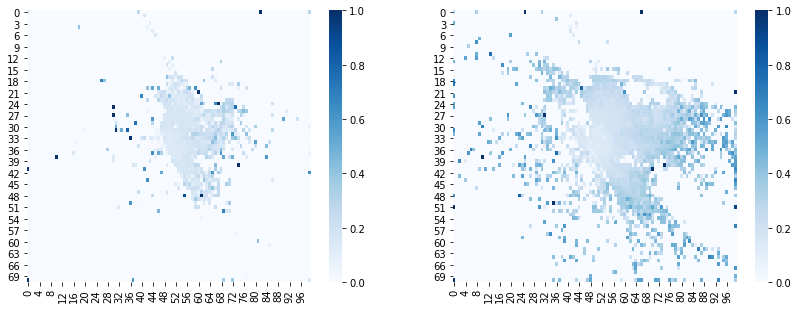

In [24]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.heatmap(pickup_speed_dist.T, cmap=plt.cm.Blues, ax=ax[0])
sns.heatmap(dropoff_speed_dist.T, cmap=plt.cm.Blues, ax=ax[1])

In [25]:
# 根据train的位置速度 计算train/test的位置速度

# 这个方法太慢了
# full_df['pickup_pos_speed'] = full_df.apply(lambda df: pickup_speed_dist.values[df['idx_pickup_longitude'], df['idx_pickup_latitude']], axis=1)

full_df['pickup_pos_speed'] = 0
full_df['dropoff_pos_speed'] = 0

# for i in range(max_longitude_idx+1):
#     pickup_cond1 = (full_df['idx_pickup_longitude'] == i)
#     dropoff_cond1 = (full_df['idx_dropoff_longitude'] == i)

#     for j in range(max_latitude_idx+1):
#         pickup_cond2 = (full_df['idx_pickup_latitude'] == j)
#         dropoff_cond2 = (full_df['idx_dropoff_latitude'] == j)
        
#         full_df.loc[pickup_cond1 & pickup_cond2, 'pickup_pos_speed'] = pickup_speed_dist[i][j]
#         full_df.loc[dropoff_cond1 & dropoff_cond2, 'dropoff_pos_speed'] = dropoff_speed_dist[i][j]
        
# full_df[['pickup_pos_speed', 'dropoff_pos_speed']].to_csv('./data/input/tmp_pos_speed.csv', index=False)

full_df[['pickup_pos_speed', 'dropoff_pos_speed']] = pd.read_csv('./data/input/tmp_pos_speed.csv').values

add_features(['pickup_pos_speed', 'dropoff_pos_speed'])

In [26]:
# 计算起点到终点范围内的速度

full_df['range_speed_by_pickup_speed'] = 0
full_df['range_speed_by_dropoff_speed'] = 0

# # 计算哪些位置是非0的
# pickup_speed_dist_isnotnan = np.where(pickup_speed_dist == 0, 0, 1)
# dropoff_speed_dist_isnotnan = np.where(dropoff_speed_dist == 0, 0, 1)

# full_df['min_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].min(axis=1)
# full_df['max_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].max(axis=1)
# full_df['min_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].min(axis=1)
# full_df['max_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].max(axis=1)

# full_df['range_speed_by_pickup_speed'] = full_df.apply(
#     lambda df: 
#         pickup_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         pickup_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df['range_speed_by_dropoff_speed'] = full_df.apply(
#     lambda df: 
#         dropoff_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         dropoff_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']].to_csv('./data/input/tmp_range_speed.csv', index=False)

full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']] = pd.read_csv('./data/input/tmp_range_speed.csv').values

add_features(['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed'])

* PCA coordinates

对坐标PCA后，虽然维度没有变，仍然是2D，但是有助于树模型分类

In [27]:
coords = np.vstack((
    full_df[['pickup_latitude', 'pickup_longitude']].values,
    full_df[['dropoff_latitude', 'dropoff_longitude']].values,
))

pca = PCA().fit(coords)

new_feats = ['pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']
for f in new_feats:
    full_df[f] = 0

full_df[['pickup_pca0', 'pickup_pca1']] = pca.transform(full_df[['pickup_latitude', 'pickup_longitude']])
full_df[['dropoff_pca0', 'dropoff_pca1']] = pca.transform(full_df[['dropoff_latitude', 'dropoff_longitude']])

add_features(new_feats)

## EDA

In [28]:
tdf = full_df.copy()

tdf = tdf[tdf['trip_duration'] < 500000]
tdf = tdf[tdf['pickup_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['pickup_latitude'].between(min_latitude, max_latitude)]
tdf = tdf[tdf['dropoff_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['dropoff_latitude'].between(min_latitude, max_latitude)]

* 上车/下车地点分布

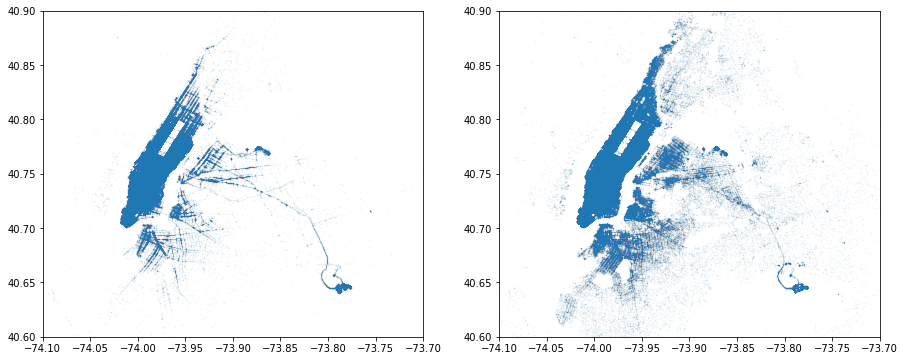

In [29]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.xlim(-74.1, -73.7)
plt.ylim(40.6, 40.9)
plt.scatter(tdf['pickup_longitude'], tdf['pickup_latitude'], s=0.05, alpha=0.1)

plt.subplot(122)
plt.xlim(-74.1, -73.7)
plt.ylim(40.6, 40.9)
plt.scatter(tdf['dropoff_longitude'], tdf['dropoff_latitude'], s=0.05, alpha=0.1)

* 可以看到 不同的位置 行驶的速度还是有区别的 

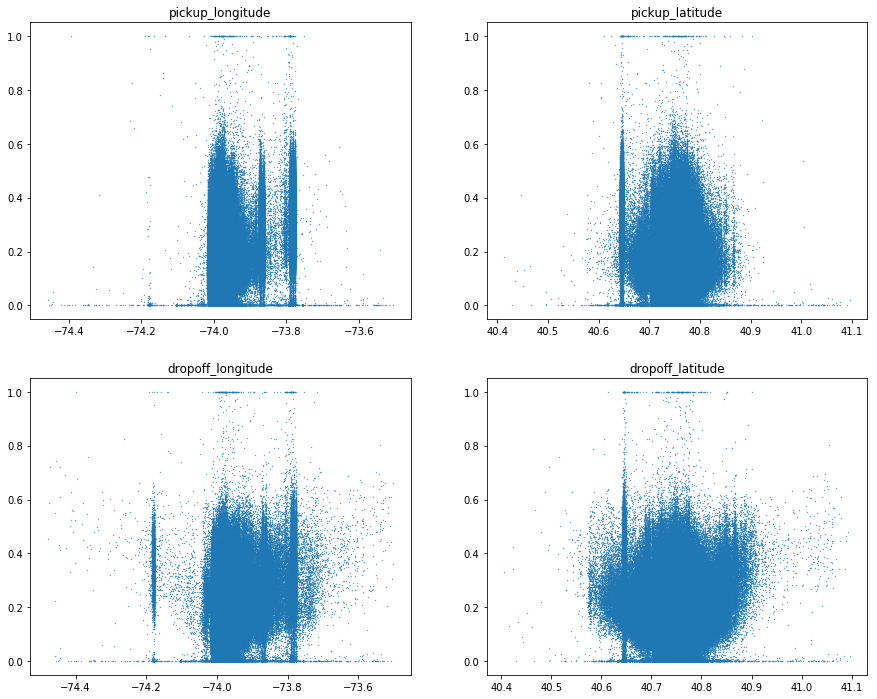

In [30]:
def show_pos(df, f):
    plt.subplots(2, 2, figsize=(15,12))
 
    for i, posf in enumerate(pos_feats):
        plt.subplot(2,2,i+1)
        plt.scatter(tdf[posf], tdf[f], s=0.1)
        plt.title(posf)
        
show_pos(tdf, 'speed')

* 速度跟周几还是很有关系的

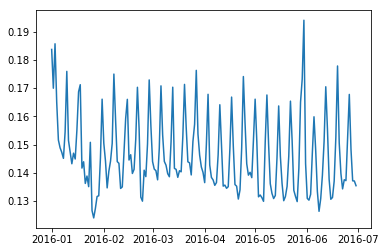

In [31]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date)['speed'].mean())

* 不同的vendor_id速度是基本一样的，但是vendor_id=1比较偏向于接时间短的单子

In [32]:
vendor_date_speed_df = tdf.groupby([tdf['vendor_id'], tdf['pickup_date']], as_index=False)[['log1p_trip_duration', 'speed']].mean()

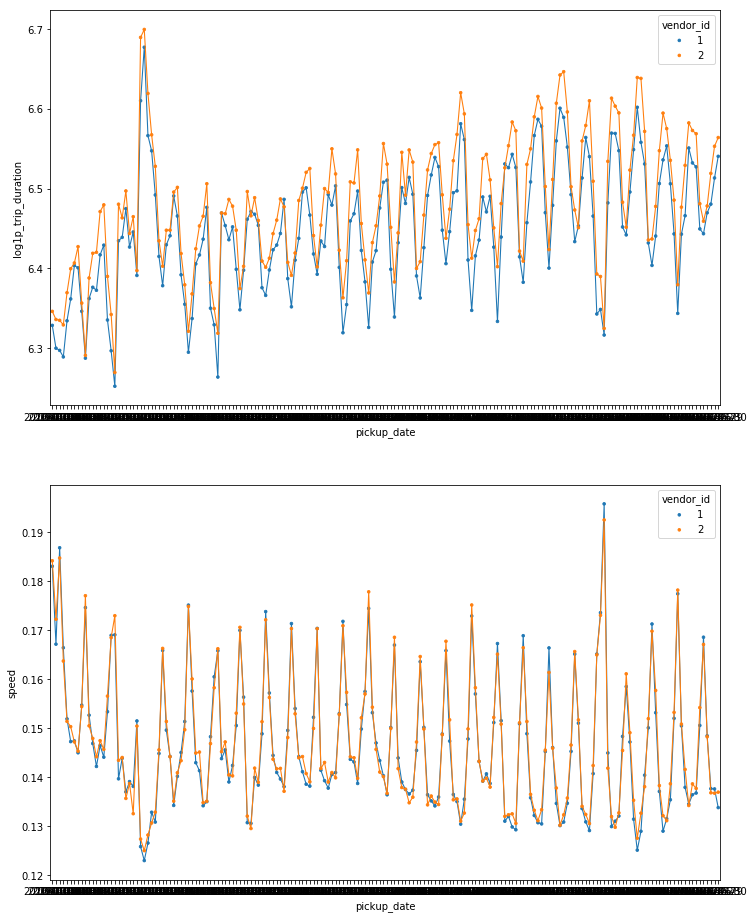

In [33]:
fig, ax = plt.subplots(2,1,figsize=(12,16))
sns.pointplot('pickup_date', 'log1p_trip_duration', 'vendor_id', data=vendor_date_speed_df, scale=0.4, ax=ax[0])
sns.pointplot('pickup_date', 'speed', 'vendor_id', data=vendor_date_speed_df, scale=0.4, ax=ax[1])

* 日订单数

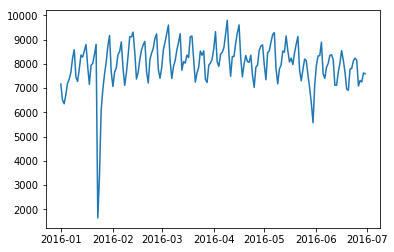

In [34]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date).size())

## 相关性

In [54]:
get_top_k_corr(full_df[feature_columns])

pickup_dayofyear                pickup_total_seconds                               0.999987
pickup_week_hour                pickup_week_hour_minute                            0.999981
pickup_longitude                pickup_pca0                                        0.999657
dropoff_longitude               dropoff_pca0                                       0.999576
pickup_longitude                pickup_longitude_bin                               0.999191
dropoff_longitude               dropoff_longitude_bin                              0.999176
pickup_hour                     pickup_hour_minute                                 0.998983
pickup_longitude_bin            pickup_pca0                                        0.998874
dropoff_longitude_bin           dropoff_pca0                                       0.998761
gp_speed_dropoff_cluster_label  gp_speed_dropoff_cluster_label_pickup_dayofweek    0.998594
dtype: float64

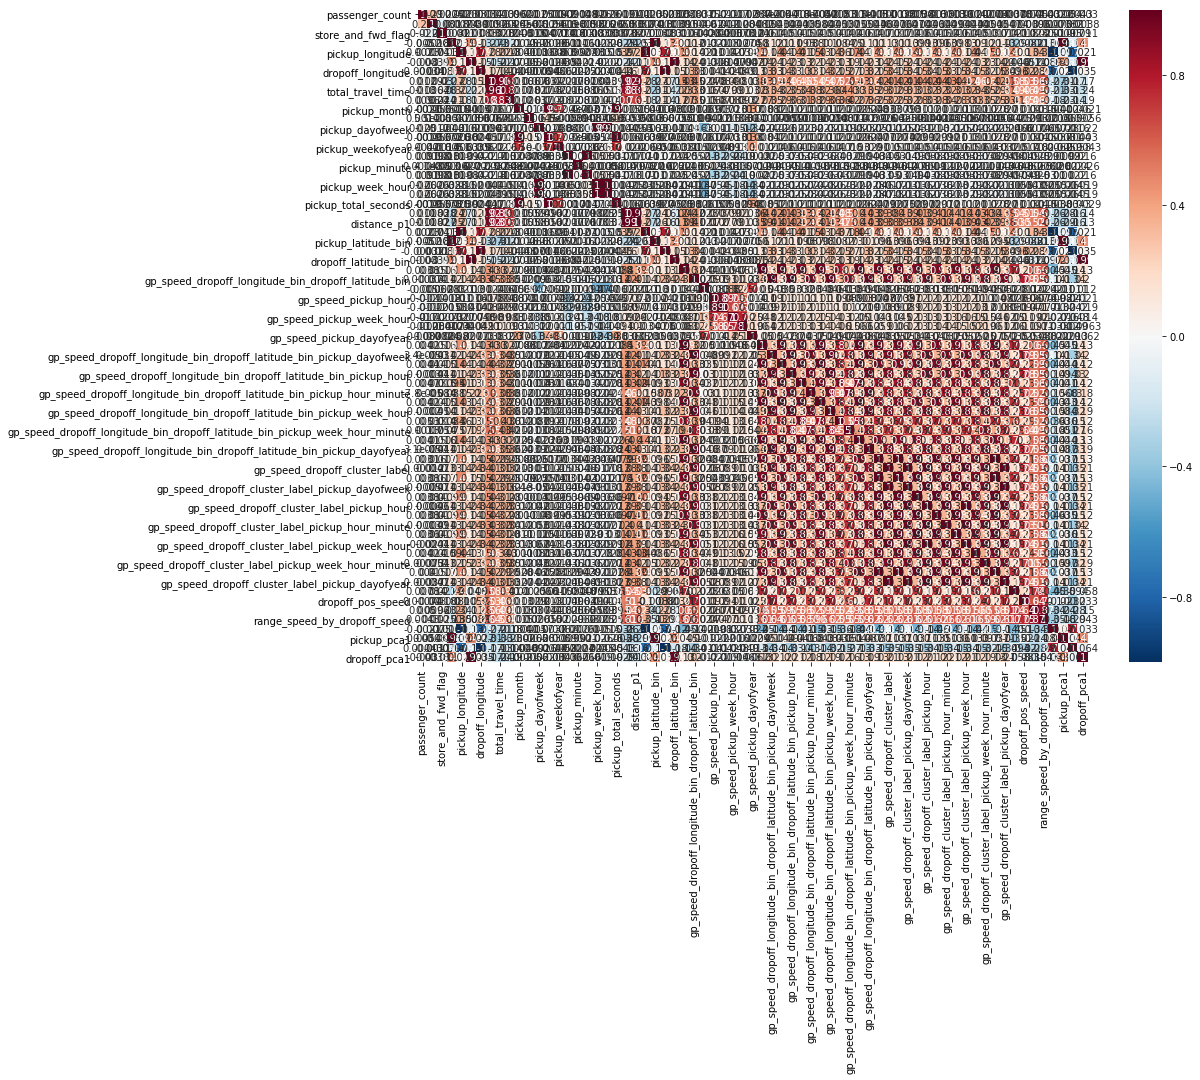

In [35]:
# fig, ax = plt.subplots(1,1,figsize=(15,12))
# corr_df = full_df[feature_columns].corr()
# sns.heatmap(corr_df, annot=True, cmap=plt.cm.RdBu_r)

## 预处理

In [67]:
trn_df = full_df.loc['train']
tst_df = full_df.loc['test']

X = trn_df[feature_columns].values
y = trn_df['log1p_trip_duration'].values
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns].values
# y_tst = tst_df['log1p_trip_duration'].values

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

## LightGBM

In [68]:
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'learning_rate': 0.2,
#     'max_depth': 6,
#     'num_leaves': 63,
#     'bagging_fraction': 0.8,
#     'feature_fraction': 0.6,
#     'min_data_in_leaf': 10,
# #     'min_sum_hessian_in_leaf': 1e-3,
#     'lambda_l1': 15,
#     'verbose': 0,
#     'seed': 0,
# }

# # search_param_name, search_param_values = 'max_depth', [5,6,7,8]
# # search_param_name, search_param_values = 'bagging_fraction', [0.5, 0.6, 0.7, 0.8]
# # search_param_name, search_param_values = 'feature_fraction', [0.5, 0.6, 0.7, 0.8]
# # search_param_name, search_param_values = 'num_leaves', [7, 15, 31, 63]
# search_param_name, search_param_values = 'min_data_in_leaf', [10,20,30]
# # search_param_name, search_param_values = 'min_sum_hessian_in_leaf', [1e-4, 1e-3, 1e-2]
# # search_param_name, search_param_values = 'lambda_l1', [5, 10, 15, 20]

# for v in search_param_values:
#     params[search_param_name] = v
#     print(search_param_name, v)
#     bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20, verbose_eval=False)
#     print(bst.best_score)
#     print('--------------------------')

In [69]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.2,
    'max_depth': 6,
    'num_leaves': 63,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.6,
    'min_data_in_leaf': 10,
#     'min_sum_hessian_in_leaf': 1e-3,
    'lambda_l1': 15,
    'verbose': 0,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)
bst.save_model('./data/output/model.txt')

[1]	training's rmse: 0.694084	valid_1's rmse: 0.69209
Train until valid scores didn't improve in 20 rounds.
[2]	training's rmse: 0.619482	valid_1's rmse: 0.617605
[3]	training's rmse: 0.564857	valid_1's rmse: 0.562985
[4]	training's rmse: 0.523715	valid_1's rmse: 0.522021
[5]	training's rmse: 0.494733	valid_1's rmse: 0.493205
[6]	training's rmse: 0.473935	valid_1's rmse: 0.472575
[7]	training's rmse: 0.45837	valid_1's rmse: 0.457172
[8]	training's rmse: 0.447853	valid_1's rmse: 0.446815
[9]	training's rmse: 0.439904	valid_1's rmse: 0.439007
[10]	training's rmse: 0.434333	valid_1's rmse: 0.433577
[11]	training's rmse: 0.430033	valid_1's rmse: 0.42926
[12]	training's rmse: 0.426221	valid_1's rmse: 0.425567
[13]	training's rmse: 0.423179	valid_1's rmse: 0.422639
[14]	training's rmse: 0.42115	valid_1's rmse: 0.420679
[15]	training's rmse: 0.419159	valid_1's rmse: 0.418784
[16]	training's rmse: 0.417592	valid_1's rmse: 0.417265
[17]	training's rmse: 0.416034	valid_1's rmse: 0.415749
[18]	tr

[148]	training's rmse: 0.379392	valid_1's rmse: 0.385621
[149]	training's rmse: 0.379243	valid_1's rmse: 0.385503
[150]	training's rmse: 0.379209	valid_1's rmse: 0.385477
[151]	training's rmse: 0.379084	valid_1's rmse: 0.385394
[152]	training's rmse: 0.378957	valid_1's rmse: 0.385337
[153]	training's rmse: 0.378891	valid_1's rmse: 0.385284
[154]	training's rmse: 0.378838	valid_1's rmse: 0.385261
[155]	training's rmse: 0.378748	valid_1's rmse: 0.385186
[156]	training's rmse: 0.378614	valid_1's rmse: 0.38509
[157]	training's rmse: 0.378502	valid_1's rmse: 0.385072
[158]	training's rmse: 0.378432	valid_1's rmse: 0.385021
[159]	training's rmse: 0.378364	valid_1's rmse: 0.384995
[160]	training's rmse: 0.378289	valid_1's rmse: 0.384964
[161]	training's rmse: 0.378212	valid_1's rmse: 0.384903
[162]	training's rmse: 0.378095	valid_1's rmse: 0.38484
[163]	training's rmse: 0.37792	valid_1's rmse: 0.384864
[164]	training's rmse: 0.377828	valid_1's rmse: 0.384805
[165]	training's rmse: 0.377719	va

[294]	training's rmse: 0.367702	valid_1's rmse: 0.379793
[295]	training's rmse: 0.367667	valid_1's rmse: 0.379771
[296]	training's rmse: 0.367596	valid_1's rmse: 0.379757
[297]	training's rmse: 0.367474	valid_1's rmse: 0.3798
[298]	training's rmse: 0.367434	valid_1's rmse: 0.379778
[299]	training's rmse: 0.367408	valid_1's rmse: 0.379766
[300]	training's rmse: 0.367355	valid_1's rmse: 0.379738
[301]	training's rmse: 0.3673	valid_1's rmse: 0.379732
[302]	training's rmse: 0.367233	valid_1's rmse: 0.379716
[303]	training's rmse: 0.367179	valid_1's rmse: 0.37971
[304]	training's rmse: 0.367103	valid_1's rmse: 0.379702
[305]	training's rmse: 0.367064	valid_1's rmse: 0.379675
[306]	training's rmse: 0.367033	valid_1's rmse: 0.379659
[307]	training's rmse: 0.366962	valid_1's rmse: 0.379639
[308]	training's rmse: 0.366912	valid_1's rmse: 0.379606
[309]	training's rmse: 0.366834	valid_1's rmse: 0.37959
[310]	training's rmse: 0.366767	valid_1's rmse: 0.37956
[311]	training's rmse: 0.366735	valid_

[440]	training's rmse: 0.360235	valid_1's rmse: 0.377315
[441]	training's rmse: 0.360171	valid_1's rmse: 0.377291
[442]	training's rmse: 0.360127	valid_1's rmse: 0.377274
[443]	training's rmse: 0.360084	valid_1's rmse: 0.377271
[444]	training's rmse: 0.360027	valid_1's rmse: 0.377235
[445]	training's rmse: 0.359952	valid_1's rmse: 0.377249
[446]	training's rmse: 0.359866	valid_1's rmse: 0.377256
[447]	training's rmse: 0.35984	valid_1's rmse: 0.377252
[448]	training's rmse: 0.359793	valid_1's rmse: 0.377231
[449]	training's rmse: 0.359753	valid_1's rmse: 0.377214
[450]	training's rmse: 0.359703	valid_1's rmse: 0.377195
[451]	training's rmse: 0.359665	valid_1's rmse: 0.377181
[452]	training's rmse: 0.359611	valid_1's rmse: 0.377184
[453]	training's rmse: 0.359561	valid_1's rmse: 0.377174
[454]	training's rmse: 0.359493	valid_1's rmse: 0.377181
[455]	training's rmse: 0.359472	valid_1's rmse: 0.377176
[456]	training's rmse: 0.359446	valid_1's rmse: 0.377167
[457]	training's rmse: 0.359419	

[586]	training's rmse: 0.35418	valid_1's rmse: 0.375862
[587]	training's rmse: 0.354151	valid_1's rmse: 0.375865
[588]	training's rmse: 0.35412	valid_1's rmse: 0.375853
[589]	training's rmse: 0.354031	valid_1's rmse: 0.375865
[590]	training's rmse: 0.354015	valid_1's rmse: 0.375866
[591]	training's rmse: 0.353965	valid_1's rmse: 0.375863
[592]	training's rmse: 0.353943	valid_1's rmse: 0.375864
[593]	training's rmse: 0.353882	valid_1's rmse: 0.375877
[594]	training's rmse: 0.353836	valid_1's rmse: 0.375883
[595]	training's rmse: 0.353808	valid_1's rmse: 0.37588
[596]	training's rmse: 0.353767	valid_1's rmse: 0.375901
[597]	training's rmse: 0.353737	valid_1's rmse: 0.375895
[598]	training's rmse: 0.353689	valid_1's rmse: 0.375903
[599]	training's rmse: 0.353661	valid_1's rmse: 0.375892
[600]	training's rmse: 0.35363	valid_1's rmse: 0.375896
[601]	training's rmse: 0.353602	valid_1's rmse: 0.375885
[602]	training's rmse: 0.353572	valid_1's rmse: 0.375872
[603]	training's rmse: 0.353524	val

[732]	training's rmse: 0.349044	valid_1's rmse: 0.375
[733]	training's rmse: 0.348998	valid_1's rmse: 0.374996
[734]	training's rmse: 0.348985	valid_1's rmse: 0.374994
[735]	training's rmse: 0.348957	valid_1's rmse: 0.374995
[736]	training's rmse: 0.348926	valid_1's rmse: 0.374985
[737]	training's rmse: 0.3489	valid_1's rmse: 0.37498
[738]	training's rmse: 0.348862	valid_1's rmse: 0.374975
[739]	training's rmse: 0.34883	valid_1's rmse: 0.374966
[740]	training's rmse: 0.348803	valid_1's rmse: 0.37496
[741]	training's rmse: 0.348773	valid_1's rmse: 0.374951
[742]	training's rmse: 0.348749	valid_1's rmse: 0.374951
[743]	training's rmse: 0.348712	valid_1's rmse: 0.37494
[744]	training's rmse: 0.348674	valid_1's rmse: 0.374939
[745]	training's rmse: 0.348619	valid_1's rmse: 0.374932
[746]	training's rmse: 0.348573	valid_1's rmse: 0.374907
[747]	training's rmse: 0.348528	valid_1's rmse: 0.374908
[748]	training's rmse: 0.348487	valid_1's rmse: 0.374905
[749]	training's rmse: 0.348454	valid_1'

[877]	training's rmse: 0.344539	valid_1's rmse: 0.374481
[878]	training's rmse: 0.344495	valid_1's rmse: 0.374488
[879]	training's rmse: 0.344477	valid_1's rmse: 0.374489
[880]	training's rmse: 0.344452	valid_1's rmse: 0.374482
[881]	training's rmse: 0.344414	valid_1's rmse: 0.37448
[882]	training's rmse: 0.344379	valid_1's rmse: 0.374467
[883]	training's rmse: 0.344358	valid_1's rmse: 0.374461
[884]	training's rmse: 0.344335	valid_1's rmse: 0.374451
[885]	training's rmse: 0.344311	valid_1's rmse: 0.374452
[886]	training's rmse: 0.344298	valid_1's rmse: 0.374446
[887]	training's rmse: 0.34426	valid_1's rmse: 0.374452
[888]	training's rmse: 0.344206	valid_1's rmse: 0.374458
[889]	training's rmse: 0.344187	valid_1's rmse: 0.374449
[890]	training's rmse: 0.344146	valid_1's rmse: 0.374475
[891]	training's rmse: 0.344126	valid_1's rmse: 0.374473
[892]	training's rmse: 0.344112	valid_1's rmse: 0.374468
[893]	training's rmse: 0.344089	valid_1's rmse: 0.374455
[894]	training's rmse: 0.344025	v

In [70]:
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
                init_model='./data/output/model.txt', 
                learning_rates=lambda iter: 0.2 * (0.99 ** iter))

[1002]	training's rmse: 0.341274	valid_1's rmse: 0.374002
Train until valid scores didn't improve in 20 rounds.
[1003]	training's rmse: 0.341225	valid_1's rmse: 0.373986
[1004]	training's rmse: 0.341154	valid_1's rmse: 0.373993
[1005]	training's rmse: 0.341129	valid_1's rmse: 0.373989
[1006]	training's rmse: 0.341102	valid_1's rmse: 0.373985
[1007]	training's rmse: 0.341078	valid_1's rmse: 0.373995
[1008]	training's rmse: 0.341062	valid_1's rmse: 0.37399
[1009]	training's rmse: 0.341027	valid_1's rmse: 0.373976
[1010]	training's rmse: 0.341012	valid_1's rmse: 0.373972
[1011]	training's rmse: 0.340995	valid_1's rmse: 0.373975
[1012]	training's rmse: 0.340979	valid_1's rmse: 0.37397
[1013]	training's rmse: 0.340955	valid_1's rmse: 0.373976
[1014]	training's rmse: 0.340935	valid_1's rmse: 0.373975
[1015]	training's rmse: 0.340914	valid_1's rmse: 0.37397
[1016]	training's rmse: 0.340904	valid_1's rmse: 0.373966
[1017]	training's rmse: 0.340891	valid_1's rmse: 0.373968
[1018]	training's rms

[1143]	training's rmse: 0.339425	valid_1's rmse: 0.373771
[1144]	training's rmse: 0.33942	valid_1's rmse: 0.37377
[1145]	training's rmse: 0.339414	valid_1's rmse: 0.37377
[1146]	training's rmse: 0.33941	valid_1's rmse: 0.373769
[1147]	training's rmse: 0.339408	valid_1's rmse: 0.373769
[1148]	training's rmse: 0.339399	valid_1's rmse: 0.373765
[1149]	training's rmse: 0.339395	valid_1's rmse: 0.373765
[1150]	training's rmse: 0.339382	valid_1's rmse: 0.37376
[1151]	training's rmse: 0.339377	valid_1's rmse: 0.373759
[1152]	training's rmse: 0.339373	valid_1's rmse: 0.373757
[1153]	training's rmse: 0.339368	valid_1's rmse: 0.373755
[1154]	training's rmse: 0.339365	valid_1's rmse: 0.373754
[1155]	training's rmse: 0.33936	valid_1's rmse: 0.373752
[1156]	training's rmse: 0.339359	valid_1's rmse: 0.373752
[1157]	training's rmse: 0.339355	valid_1's rmse: 0.37375
[1158]	training's rmse: 0.339348	valid_1's rmse: 0.373751
[1159]	training's rmse: 0.339345	valid_1's rmse: 0.373751
[1160]	training's rms

[1286]	training's rmse: 0.33902	valid_1's rmse: 0.373698
[1287]	training's rmse: 0.339019	valid_1's rmse: 0.373698
[1288]	training's rmse: 0.339018	valid_1's rmse: 0.373697
[1289]	training's rmse: 0.339016	valid_1's rmse: 0.373697
[1290]	training's rmse: 0.339015	valid_1's rmse: 0.373698
[1291]	training's rmse: 0.339013	valid_1's rmse: 0.373697
[1292]	training's rmse: 0.339011	valid_1's rmse: 0.373697
[1293]	training's rmse: 0.339009	valid_1's rmse: 0.373697
[1294]	training's rmse: 0.339009	valid_1's rmse: 0.373697
[1295]	training's rmse: 0.339007	valid_1's rmse: 0.373697
[1296]	training's rmse: 0.339007	valid_1's rmse: 0.373697
[1297]	training's rmse: 0.339006	valid_1's rmse: 0.373697
[1298]	training's rmse: 0.339006	valid_1's rmse: 0.373696
[1299]	training's rmse: 0.339005	valid_1's rmse: 0.373696
[1300]	training's rmse: 0.339004	valid_1's rmse: 0.373696
[1301]	training's rmse: 0.339004	valid_1's rmse: 0.373696
[1302]	training's rmse: 0.339003	valid_1's rmse: 0.373696
[1303]	training

[1429]	training's rmse: 0.338928	valid_1's rmse: 0.373683
[1430]	training's rmse: 0.338928	valid_1's rmse: 0.373683
[1431]	training's rmse: 0.338927	valid_1's rmse: 0.373683
[1432]	training's rmse: 0.338927	valid_1's rmse: 0.373683
[1433]	training's rmse: 0.338927	valid_1's rmse: 0.373683
[1434]	training's rmse: 0.338926	valid_1's rmse: 0.373683
[1435]	training's rmse: 0.338926	valid_1's rmse: 0.373683
[1436]	training's rmse: 0.338926	valid_1's rmse: 0.373683
[1437]	training's rmse: 0.338925	valid_1's rmse: 0.373683
[1438]	training's rmse: 0.338925	valid_1's rmse: 0.373683
[1439]	training's rmse: 0.338925	valid_1's rmse: 0.373683
[1440]	training's rmse: 0.338925	valid_1's rmse: 0.373683
[1441]	training's rmse: 0.338924	valid_1's rmse: 0.373683
[1442]	training's rmse: 0.338924	valid_1's rmse: 0.373683
[1443]	training's rmse: 0.338924	valid_1's rmse: 0.373683
[1444]	training's rmse: 0.338924	valid_1's rmse: 0.373683
[1445]	training's rmse: 0.338924	valid_1's rmse: 0.373683
[1446]	trainin

[1573]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1574]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1575]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1576]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1577]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1578]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1579]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1580]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1581]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1582]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1583]	training's rmse: 0.338902	valid_1's rmse: 0.373679
[1584]	training's rmse: 0.338901	valid_1's rmse: 0.373679
[1585]	training's rmse: 0.338901	valid_1's rmse: 0.373679
[1586]	training's rmse: 0.338901	valid_1's rmse: 0.373679
[1587]	training's rmse: 0.338901	valid_1's rmse: 0.373679
[1588]	training's rmse: 0.338901	valid_1's rmse: 0.373679
[1589]	training's rmse: 0.338901	valid_1's rmse: 0.373679
[1590]	trainin

[1716]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1717]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1718]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1719]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1720]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1721]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1722]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1723]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1724]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1725]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1726]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1727]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1728]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1729]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1730]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1731]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1732]	training's rmse: 0.338896	valid_1's rmse: 0.373678
[1733]	trainin

[1858]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1859]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1860]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1861]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1862]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1863]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1864]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1865]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1866]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1867]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1868]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1869]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1870]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1871]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1872]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1873]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1874]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[1875]	trainin

[2000]	training's rmse: 0.338894	valid_1's rmse: 0.373678
[2001]	training's rmse: 0.338894	valid_1's rmse: 0.373678


In [71]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
distance_p2,3960
total_travel_time,3773
total_distance,3764
pickup_hour_minute,3755
distance_p1,3571
pickup_pca0,3530
dropoff_pca0,3470
gp_speed_pickup_dayofyear,2908
dropoff_latitude,2564
pickup_total_seconds,2554


## predict

In [72]:
pred_log1p = bst.predict(X_tst)
pred_res = np.expm1(pred_log1p)

In [73]:
res_df = pd.DataFrame({
    'id': tst_df['id'],
    'trip_duration': pred_res,
})
res_df.to_csv('./data/output/submission.csv', index=False)